In [1]:
import os
import wandb
import copy 
import json

import pandas as pd 
print(pd.__version__)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import analyse_results_utils
from es_map import custom_configs
from es_map.my_brax_envs import brax_envs
# CUDA_VISIBLE_DEVICES=0 wandb agent adam_katona/uncategorized/noibtlha

1.4.2


In [2]:
np.empty(shape=[1,2])

array([[0., 1.]])

In [3]:
api = wandb.Api()
jax_es_sweep = api.sweep("adam_katona/uncategorized/0iw7zus2") # this is the combined
#jax_es_sweep = api.sweep("adam_katona/uncategorized/noibtlha") 
#jax_es_sweep = api.sweep("adam_katona/uncategorized/c7q2v97c") 
#jax_es_sweep = api.sweep("adam_katona/uncategorized/ghkaoset") 
#jax_es_sweep = api.sweep("adam_katona/uncategorized/jd18zi1o") 

sweep_runs = list(jax_es_sweep.runs)
len(sweep_runs)

24

In [4]:
def id_to_path(id):
    from glob import glob    
    glob_res = glob("/scratch/ak1774/runs/large_files_jax/*"+id, recursive = False)
    if len(glob_res) > 0:
        return glob_res[0]
    return None

In [7]:
#for i,wanddb_run in enumerate(sweep_runs):
#    print(i,wanddb_run.name,len(wanddb_run.history()))
#type(sweep_runs[27].config)
#plt.plot(sweep_runs[40].history()["generation_number"])
#sweep_runs[40].name

In [5]:
all_runs = []
failed_runs = []
for i,wanddb_run in enumerate(sweep_runs):
    if i%40 == 0:
        print(i,"/",len(sweep_runs))
    #run_logs = wanddb_run.history()
    
    config = copy.deepcopy(wanddb_run.config)
    config = custom_configs.get_config_from_index(config,config["config_index"])
    bd_descriptor = brax_envs.env_to_bd_descriptor(config["env_name"],config["env_mode"])
    config["map_elites_grid_description"] = bd_descriptor
    
    
    run_id = wanddb_run.dir.split("/")[-1]
    run = {}
    run["path"] = id_to_path(run_id)
    if run["path"] is None:
        failed_runs.append(wanddb_run.config)
        continue
    if  os.path.exists(run["path"]+"/b_archive.npy"):
        run["b_map_evolver"] = np.load(run["path"]+"/b_map_evolver.npy",allow_pickle=True)
        run["b_map_performance"] = np.load(run["path"]+"/b_map_performance.npy",allow_pickle=True)
        run["b_archive"] = np.load(run["path"]+"/b_archive.npy")
        run["wandb_run"] = wanddb_run
        run["config"] = config
        run["config_name"] = config["config_name"]
        all_runs.append(run)
    else:
        failed_runs.append(wanddb_run.config)

0 / 24


In [6]:
print("all_runs: ",len(all_runs))
print("failed_runs: ",len(failed_runs))

all_runs:  20
failed_runs:  4


In [7]:
def config_to_type(config):
    # the types i am interested in are:
    # if the ubdates are combined, we put a "_C" at the end
    acceptable_names = [
     "ME__explore",
     "ME__exploit",
     "ME__explore-exploit",
    
     "E-ME-f__exploit",
     "E-ME-f__explore-exploit",

     "E-ME-f__evolvability",
     "E-ME-f__evolvability-exploit",
     "E-ME-f__explore-evolvability-exploit",
    
     "E-ME-e__explore-evolvability-exploit",
     "E-ME-i__explore-evolvability-exploit",
    
     "MM-ME-fei__explore-evolvability-exploit",
     "ND-ME-fei__explore-evolvability-exploit",
    ]
    
    def in_mode(mode_list,mode):
        for m in mode_list:
            if mode in m:
                return True
        return False
    
    # first get the first part
    name = ""
    if config["BMAP_type_and_metrics"]["type"] == "single_map":
        if "eval_fitness" in config["BMAP_type_and_metrics"]["metrics"]:
            name += "ME__"
        else:
            name += "E-ME-"
            if "excpected_fitness" in config["BMAP_type_and_metrics"]["metrics"]:
                name += "f"
            if "evo_ent" in config["BMAP_type_and_metrics"]["metrics"] or "evo_var" in config["BMAP_type_and_metrics"]["metrics"]:
                name += "e"
            if "innovation" in config["BMAP_type_and_metrics"]["metrics"]:
                name += "i"
            name += "__"
    else:    
        if config["BMAP_type_and_metrics"]["type"] == "multi_map":
            name += "MM-ME-"
        elif config["BMAP_type_and_metrics"]["type"] == "nd_sorted_map":
            name += "ND-ME-"
            
        if "excpected_fitness" in config["BMAP_type_and_metrics"]["metrics"]:
            name += "f"
        if "evo_ent" in config["BMAP_type_and_metrics"]["metrics"] or "evo_var" in config["BMAP_type_and_metrics"]["metrics"]:
            name += "e"
        if "innovation" in config["BMAP_type_and_metrics"]["metrics"]:
            name += "i"
        name += "__"
        
    # now get the second part
    if in_mode(config["ES_UPDATES_MODES_TO_USE"],"innovation"):
        name += "explore-"
    if in_mode(config["ES_UPDATES_MODES_TO_USE"],"evo"):
        name += "evolvability-"
    if in_mode(config["ES_UPDATES_MODES_TO_USE"],"fitness"):
        name += "exploit-"
        
    # remove trailing dash
    if name[-1] == "-":
        name = name[:-1]
    
    return name
    #if name in acceptable_names:
    #    return name
    #else:
    #    return "not_interested"
    
    
def group_runs_by_type(runs):
    typed_runs = {}
    for run in runs:
        run_type = config_to_type(run["config"])
        run["ALGO_NAME"] = run_type
        if run_type != "not_interested":
            if run_type in typed_runs:
                typed_runs[run_type].append(run)
            else:
                typed_runs[run_type] = [run]
    return typed_runs
            
    
type_runs = group_runs_by_type(all_runs)


In [8]:
all_config_types = {}
for run in all_runs:
    all_config_types[run["config"]["config_index"]] = config_to_type(run["config"])
all_config_types


{0: 'ME__explore',
 11: 'ND-ME-fei__explore-evolvability-exploit',
 10: 'MM-ME-fei__explore-evolvability-exploit',
 9: 'E-ME-i__explore-evolvability-exploit',
 8: 'E-ME-e__explore-evolvability-exploit',
 7: 'E-ME-f__explore-evolvability-exploit',
 6: 'E-ME-f__evolvability-exploit',
 5: 'E-ME-f__evolvability',
 4: 'E-ME-f__explore-exploit',
 3: 'E-ME-f__exploit',
 2: 'ME__explore-exploit',
 1: 'ME__exploit'}

In [9]:
#for run in all_runs: # [run for run in all_runs if run["config"]["config_index"]==11]:
    #print(a["config"]["env_name"])
#    print(a["b_map_evolver"].shape)

In [10]:
type_runs.keys()

dict_keys(['ME__explore', 'ND-ME-fei__explore-evolvability-exploit', 'MM-ME-fei__explore-evolvability-exploit', 'E-ME-i__explore-evolvability-exploit', 'E-ME-e__explore-evolvability-exploit', 'E-ME-f__explore-evolvability-exploit', 'E-ME-f__evolvability-exploit', 'E-ME-f__evolvability', 'E-ME-f__explore-exploit', 'E-ME-f__exploit', 'ME__explore-exploit', 'ME__exploit'])

In [11]:
all_runs[0].keys()

dict_keys(['path', 'b_map_evolver', 'b_map_performance', 'b_archive', 'wandb_run', 'config', 'ALGO_NAME'])

In [12]:
all_runs[0]["b_archive"].shape

(1001, 1)

In [7]:
def add_colums_with_key(df,column_name,runs,lambda_fun):
    df[column_name] = [lambda_fun(run) for run in runs]

def get_non_empty_ratio(run):
    num_cells = run["b_map_performance"].size
    num_nonempty = sum((run["b_map_performance"] != None).reshape(-1))
    val = float(num_nonempty)/num_cells
    run["non_empty_ratio"] = val
    return val
    
def get_normal_qd_score(run):
    non_empty = run["b_map_performance"][run["b_map_performance"] != None]
    normal_fitnesses = [cell["elite"]["eval_normal_fitness"] for cell in non_empty]
    val = sum(normal_fitnesses)
    run["normal_qd_score"] = val
    return val


def get_distance_qd_score(run):
    non_empty = run["b_map_performance"][run["b_map_performance"] != None]
    normal_fitnesses = [cell["elite"]["eval_mean_dist"] for cell in non_empty]
    val = sum(normal_fitnesses)
    run["distance_qd_score"] = val
    return val

def get_best_normal_fitness(run):
    non_empty = run["b_map_performance"][run["b_map_performance"] != None]
    val = max([cell["elite"]["eval_normal_fitness"] for cell in non_empty])
    run["best_normal_fitness"] = val
    return val
    
def get_best_distance_fitness(run):
    non_empty = run["b_map_performance"][run["b_map_performance"] != None]
    val = max([cell["elite"]["eval_mean_dist"] for cell in non_empty])
    run["best_distance_fitness"] = val
    return val
    
import pandas as pd
df = pd.DataFrame()
add_colums_with_key(df,"ALGO_NAME",all_runs,lambda x : x["config_name"])
add_colums_with_key(df,"env_name",all_runs,lambda x : x["config"]["env_name"])
add_colums_with_key(df,"env_mode",all_runs,lambda x : x["config"]["env_mode"])
#add_colums_with_key(df,"map_type",all_runs,lambda x : x["config"]["BMAP_type_and_metrics"]["type"])
#add_colums_with_key(df,"map_metrics",all_runs,lambda x : "".join(x["config"]["BMAP_type_and_metrics"]["metrics"]))
#add_colums_with_key(df,"updates",all_runs,lambda x : "".join(x["config"]["ES_UPDATES_MODES_TO_USE"]))

add_colums_with_key(df,"non_empty_ratio",all_runs,get_non_empty_ratio)
add_colums_with_key(df,"normal_qd_score",all_runs,get_normal_qd_score)
add_colums_with_key(df,"distance_qd_score",all_runs,get_distance_qd_score)
add_colums_with_key(df,"best_normal_fitness",all_runs,get_best_normal_fitness)
add_colums_with_key(df,"best_distance_fitness",all_runs,get_best_distance_fitness)

df

,ALGO_NAME,env_name,env_mode,non_empty_ratio,normal_qd_score,distance_qd_score,best_normal_fitness,best_distance_fitness
0,ND-ME-fei__explore-evolvability-exploit_C,humanoid,CONTROL_FINAL_POS,0.010742,15163.218079,41.206517,1529.1759,5.0805893
1,ND-ME-fei__explore-evolvability-exploit_C,ant,CONTROL_FINAL_POS,0.019531,4421.548843,80.637403,365.79834,7.5833373
2,ND-ME-fei__explore-evolvability-exploit_C,humanoid,NORMAL_CONTACT,0.250977,187964.197266,230.761758,1025.7211,1.4879832
3,ND-ME-fei__explore-evolvability-exploit_C,ant,NORMAL_CONTACT,0.176698,73937.145279,1560.856871,490.34076,17.655712
4,ND-ME-fei__explore-evolvability-exploit,humanoid,CONTROL_FINAL_POS,0.009766,9335.893005,44.996012,1197.7096,6.396181
5,ND-ME-fei__explore-evolvability-exploit,ant,CONTROL_FINAL_POS,0.090820,10693.459288,1085.580995,438.83304,19.111694
6,ND-ME-fei__explore-evolvability-exploit,humanoid,NORMAL_CONTACT,0.797852,487975.520576,810.880273,873.1614,2.4928243
7,ND-ME-fei__explore-evolvability-exploit,ant,NORMAL_CONTACT,0.219136,-18747.358479,633.545264,323.46063,8.810379
8,E-ME-f__explore-evolvability-exploit_C+,humanoid,CONTROL_FINAL_POS,0.005859,4643.426697,19.339385,907.66364,4.3944354
9,E-ME-f__explore-evolvability-exploit_C+,ant,CONTROL_FINAL_POS,0.058594,10774.781179,569.332185,409.99496,17.145197


In [9]:
def get_unique_combinations(runs,keys):
    all_tuples = []
    for run in runs:
        all_tuples.append(tuple(run["config"][key] for key in keys))
    return list(set(all_tuples))
combinations = get_unique_combinations(all_runs,["env_name","env_mode"])
combinations


[('humanoid', 'NORMAL_CONTACT'),
 ('ant', 'NORMAL_CONTACT'),
 ('humanoid', 'CONTROL_FINAL_POS'),
 ('ant', 'CONTROL_FINAL_POS')]

In [15]:
selected_combinations = [
    ('ant', 'NORMAL_CONTACT'),
    #('ant', 'DISTANCE_CONTACT'),
    ('ant', 'DISTANCE_FINAL_POS'),
    ('halfcheetah', 'NORMAL_CONTACT'),
    #('halfcheetah', 'DISTANCE_CONTACT'),
    ('halfcheetah', 'DISTANCE_FINAL_POS'),
]

In [16]:
custom_order = [
     "ME__explore",
     "ME__exploit",
     "ME__explore-exploit",
    
     "E-ME-f__exploit",
     "E-ME-f__explore-exploit",

     "E-ME-f__evolvability",
     "E-ME-f__evolvability-exploit",
     "E-ME-f__explore-evolvability-exploit",
    
     "E-ME-e__explore-evolvability-exploit",
     "E-ME-i__explore-evolvability-exploit",
    
     "MM-ME-fei__explore-evolvability-exploit",
     "ND-ME-fei__explore-evolvability-exploit",
    ]
def get_algo_index(algo):
    if algo in custom_order:
        return custom_order.index(algo)
    else:
        return 99999
df = df.sort_values(by="ALGO_NAME",key=lambda x: x.apply(get_algo_index))
df

,ALGO_NAME,env_name,env_mode,non_empty_ratio,normal_qd_score,distance_qd_score,best_normal_fitness,best_distance_fitness
0,ME__explore,hopper,DISTANCE_FINAL_POS,0.050000,363.256322,9.144178,141.49341,2.6181073
357,ME__explore,ant,CONTROL_FINAL_POS,0.003906,-153.495956,7.601521,132.99713,2.092682
356,ME__explore,humanoid,CONTROL_FINAL_POS,0.003906,1149.052032,1.743170,357.2876,0.6819098
355,ME__explore,walker,CONTROL_FINAL_POS,0.040000,523.011299,4.199516,192.55933,1.6940706
354,ME__explore,hopper,CONTROL_FINAL_POS,0.040000,357.434662,3.659432,141.37419,1.4570819
...,...,...,...,...,...,...,...,...
15,ND-ME-fei__explore-evolvability-exploit,walker,DISTANCE_FINAL_POS,0.040000,373.989319,4.757863,161.73532,1.4860189
374,ND-ME-fei__explore-evolvability-exploit,hopper,DISTANCE_FINAL_POS,0.040000,269.556698,5.337394,118.00893,1.7152579
373,ND-ME-fei__explore-evolvability-exploit,halfcheetah,DISTANCE_FINAL_POS,0.330000,-1399.335391,373.510189,295.6818,23.912714
371,ND-ME-fei__explore-evolvability-exploit,humanoid,CONTROL_FINAL_POS,0.003906,1537.605820,3.181875,544.36115,1.1842238


In [17]:
df = df.reset_index(drop=True)

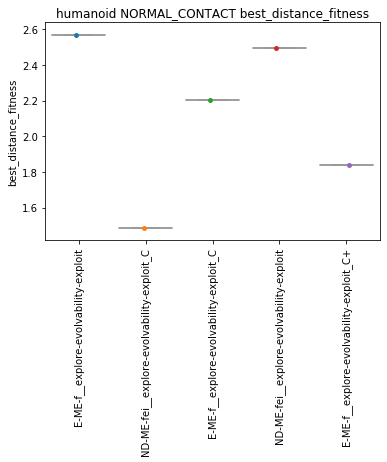

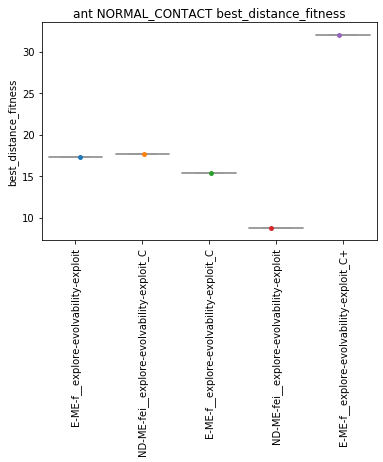

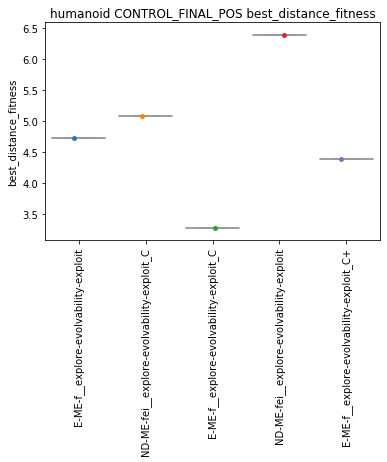

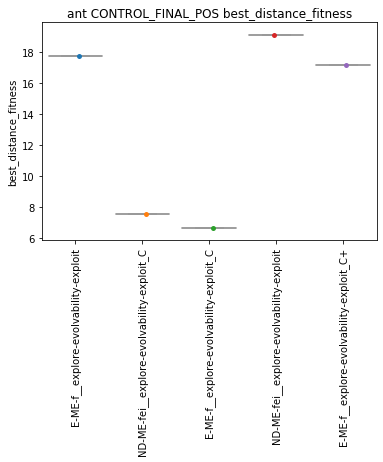

In [12]:
# seaborn plots
import seaborn as sns

metrics = [
#    "best_normal_fitness",
    "best_distance_fitness",
#    "non_empty_ratio",
#    "normal_qd_score"
]

custom_order = set([run["config_name"] for run in all_runs])

for metric in metrics:
    for env_combo in combinations:
        mask = (df["env_name"] == env_combo[0]) & (df["env_mode"] == env_combo[1])
        subset = df[mask]

        boxplot_data = [] 
        boxplot_labels = []

        for algo in custom_order:
            values = subset[subset["ALGO_NAME"]==algo][metric].astype(float)
            boxplot_data.append(values)
            boxplot_labels.append(algo)

        sns.boxplot(data=boxplot_data,color="white",saturation=0)#,whis=(0,100))
        sns.stripplot(data=boxplot_data)#,color="black")
        plt.xticks(list(range(len(boxplot_labels))),boxplot_labels,rotation = 90)
        plt.ylabel(metric)
        plt.title(env_combo[0]+" "+env_combo[1]+" "+metric)
        #plt.ylim(bottom=0)
        plt.show()

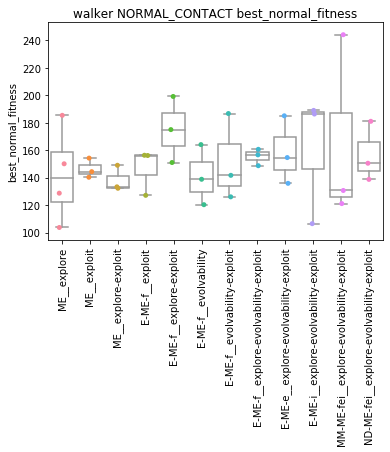

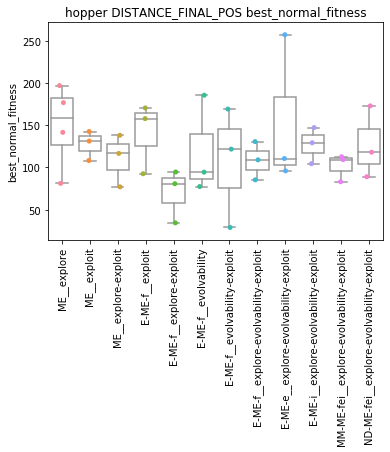

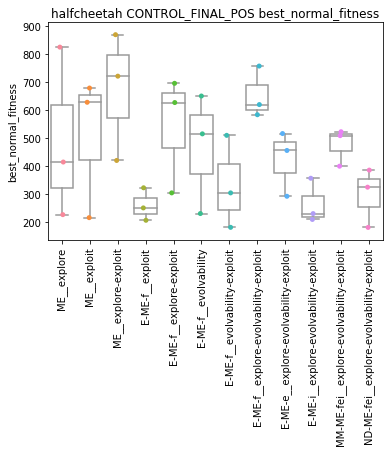

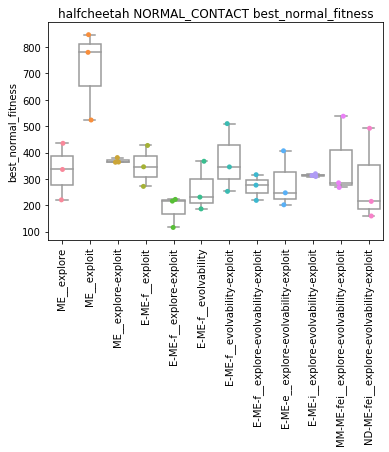

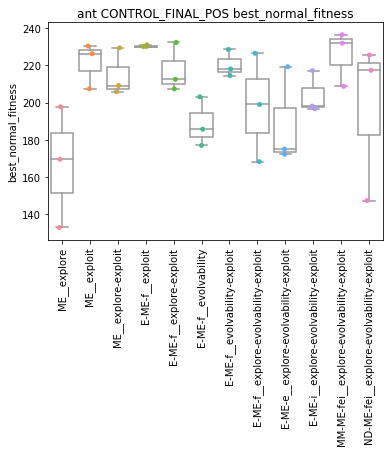

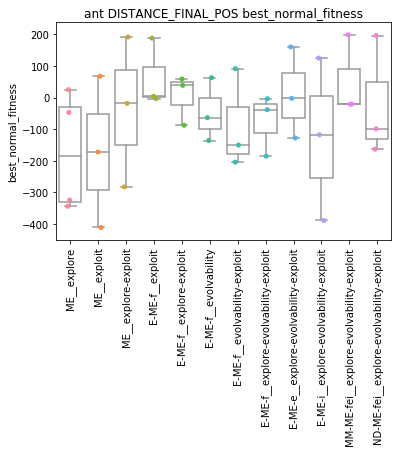

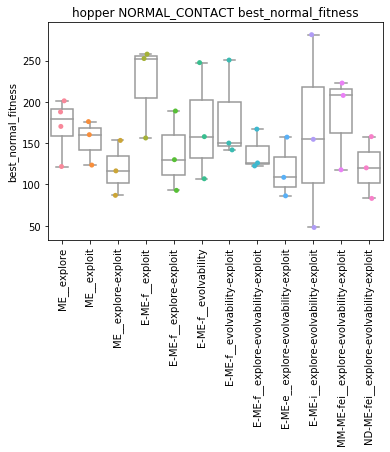

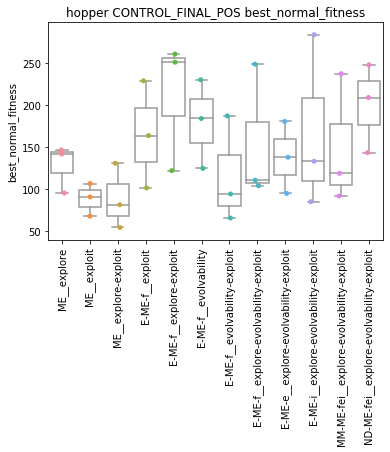

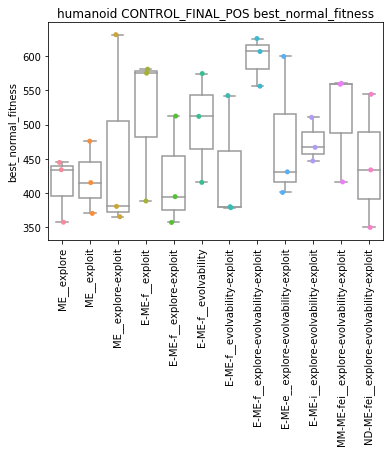

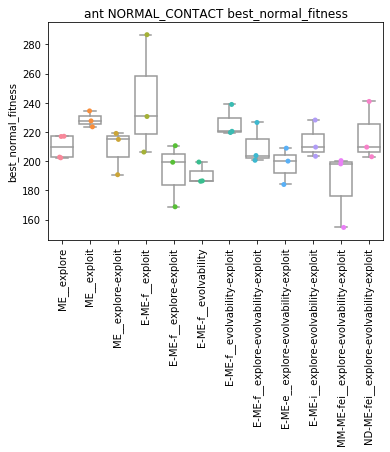

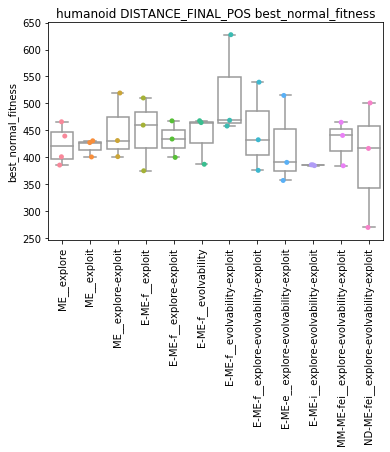

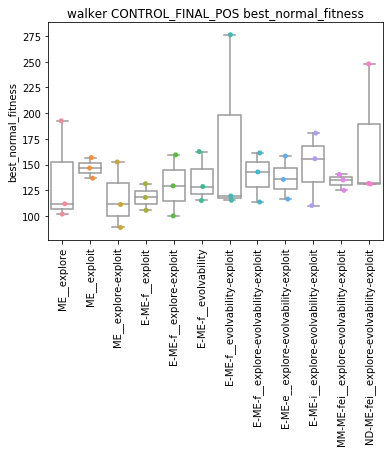

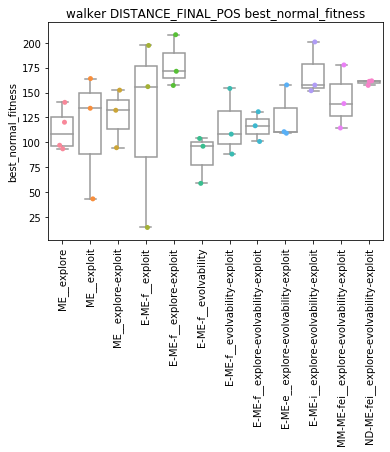

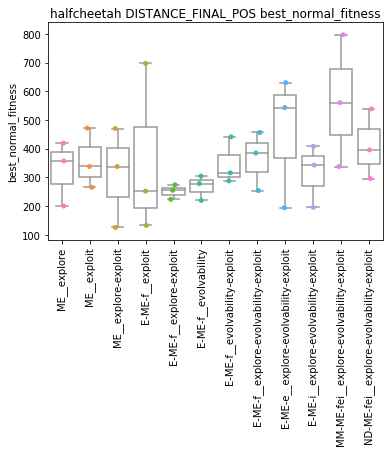

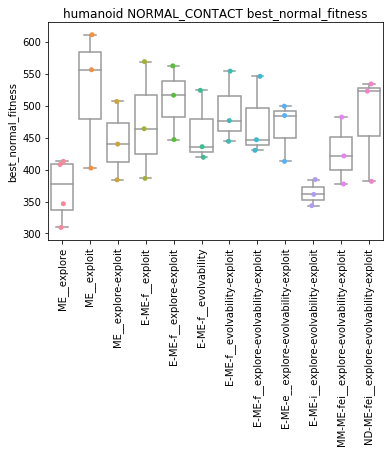

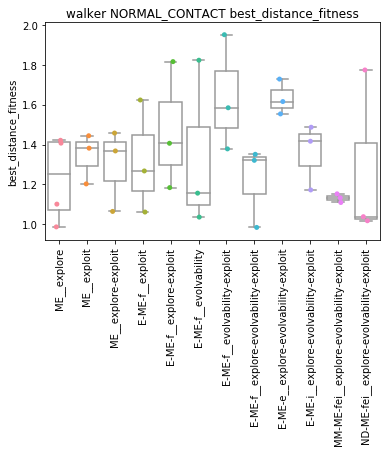

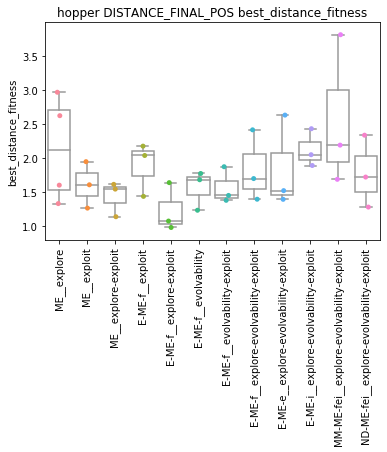

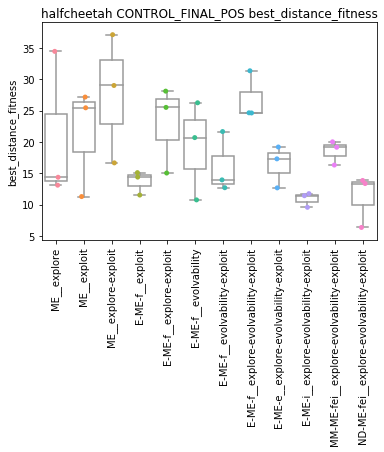

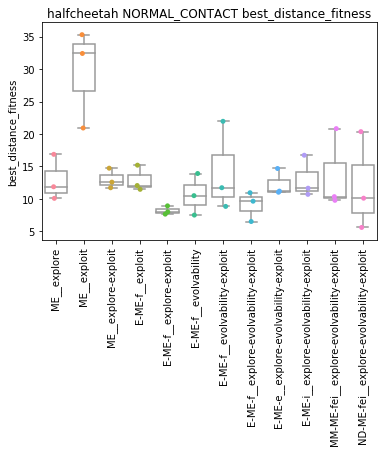

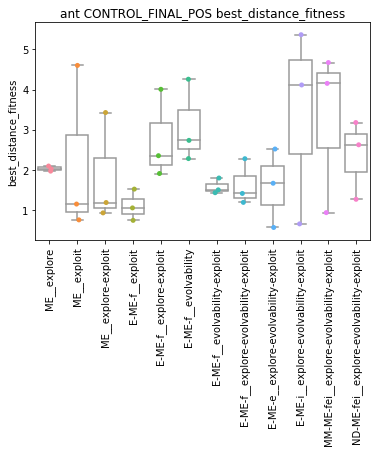

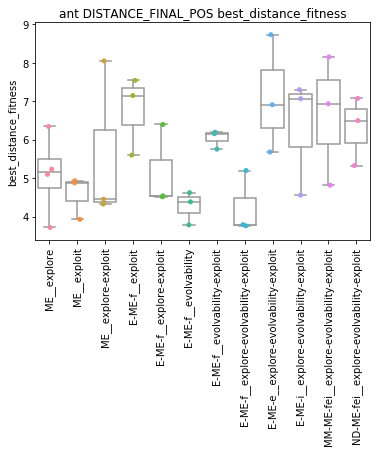

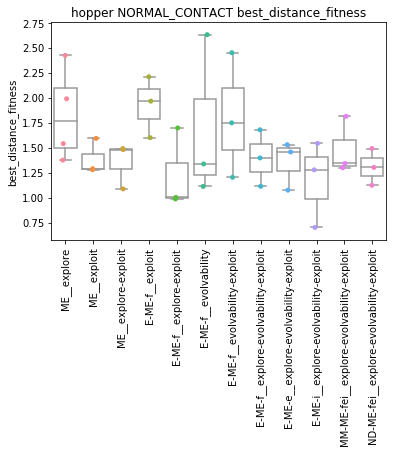

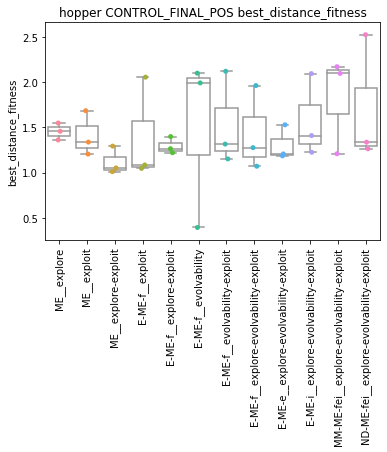

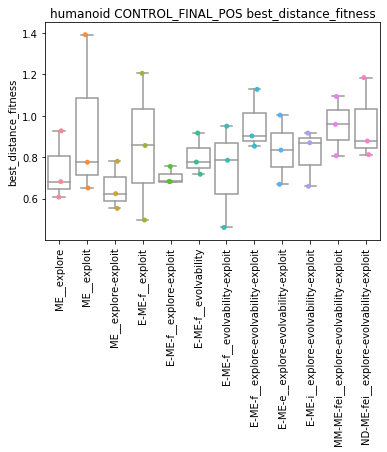

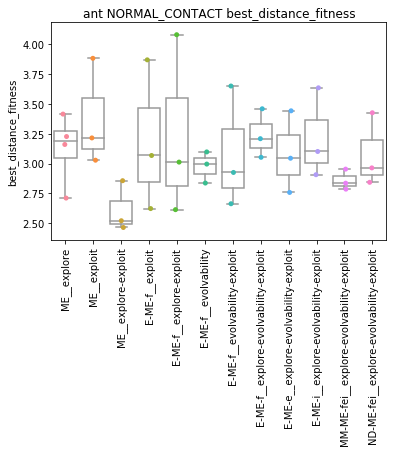

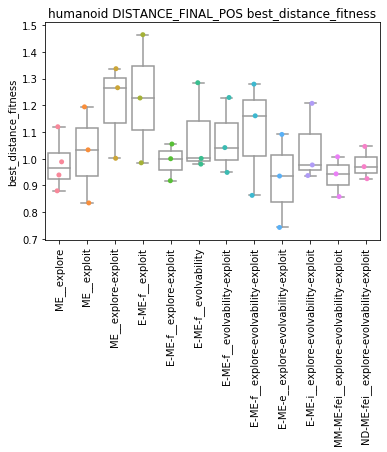

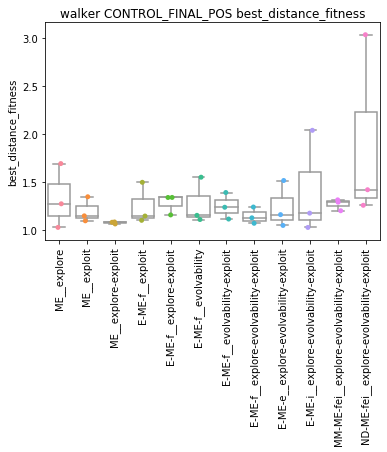

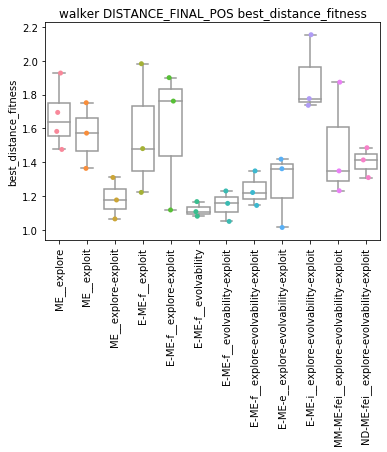

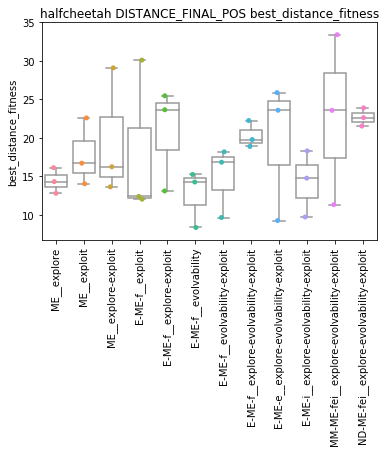

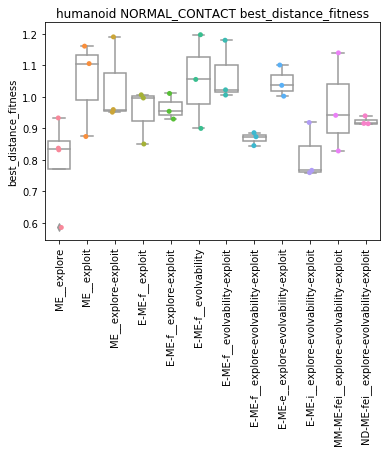

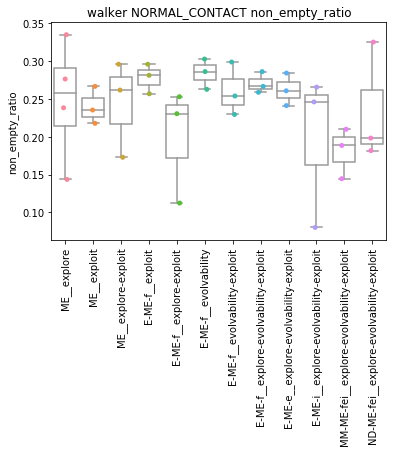

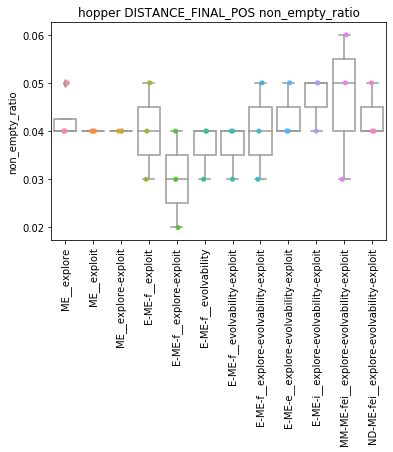

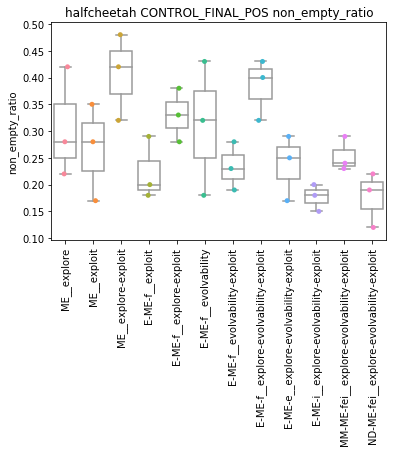

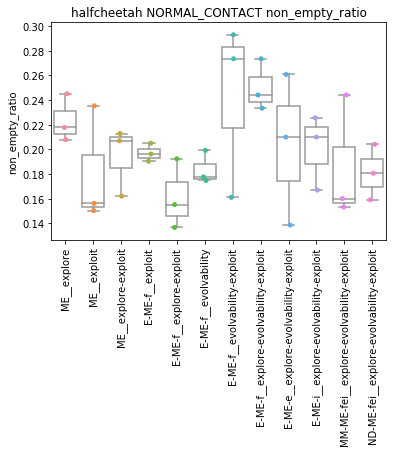

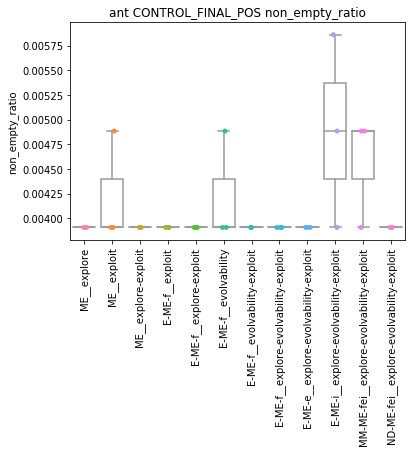

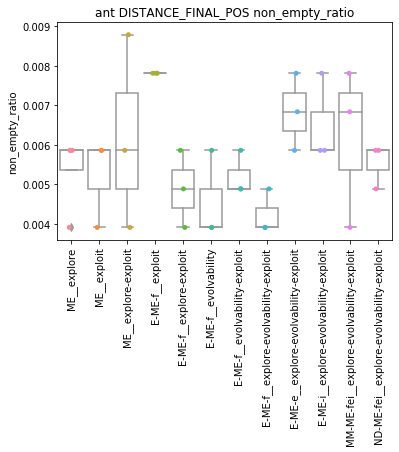

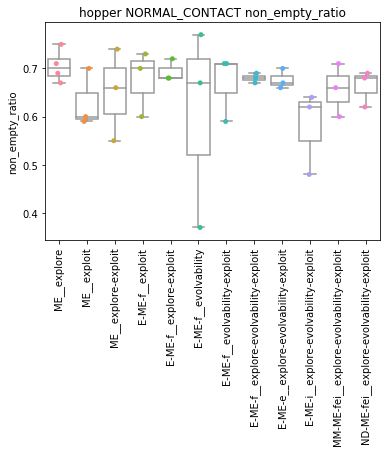

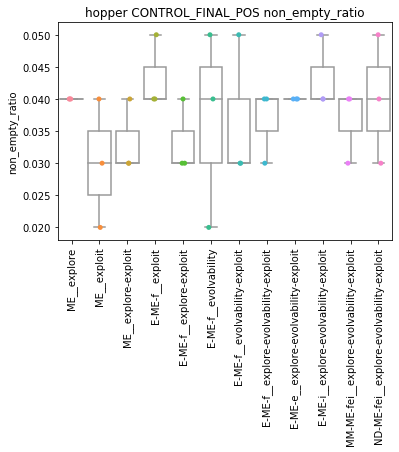

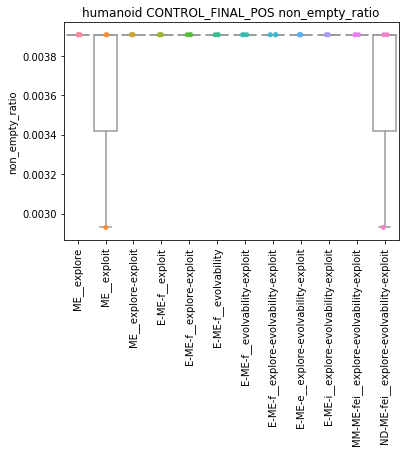

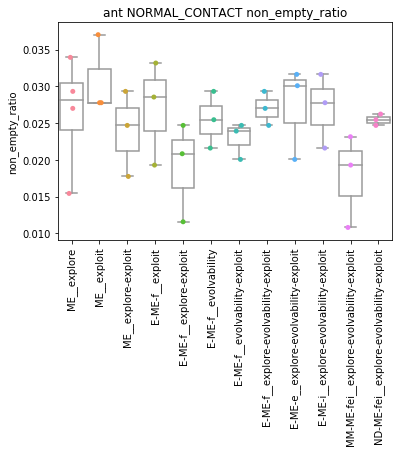

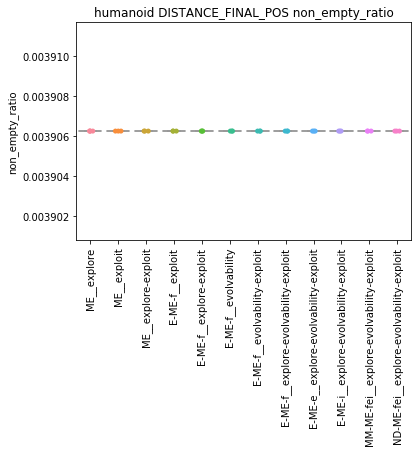

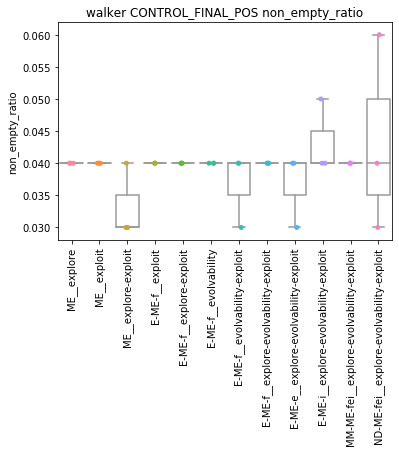

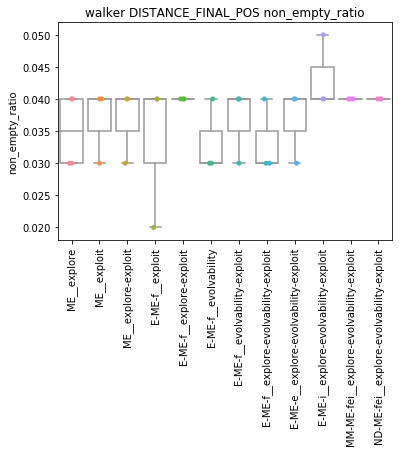

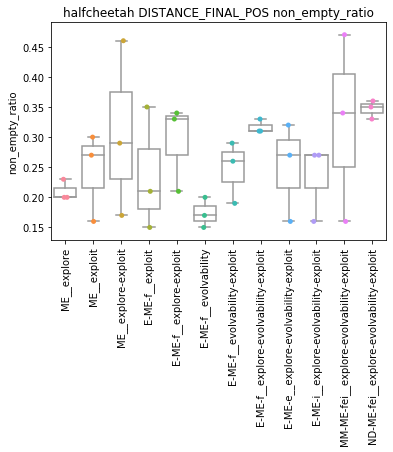

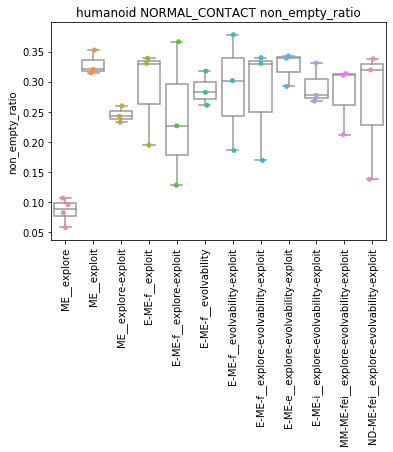

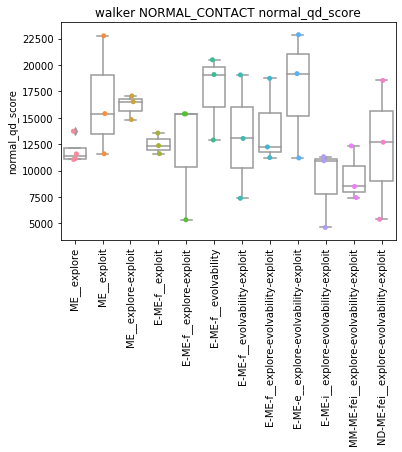

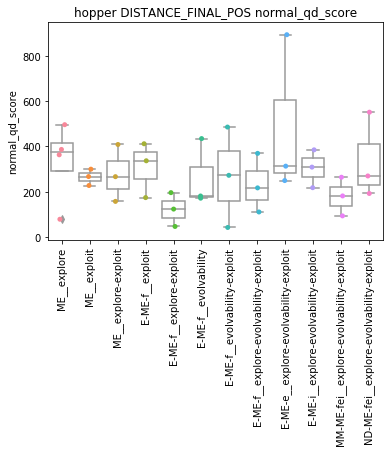

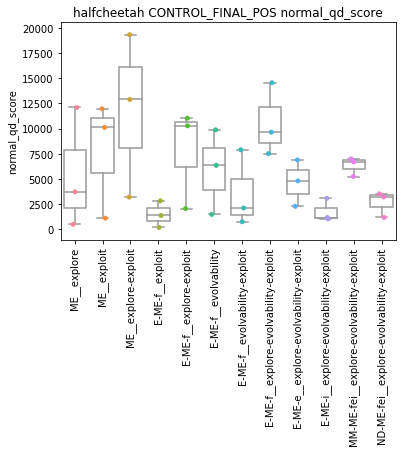

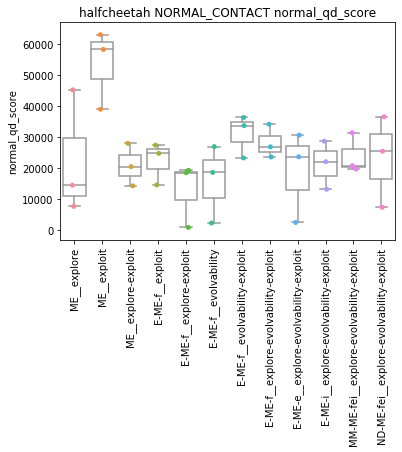

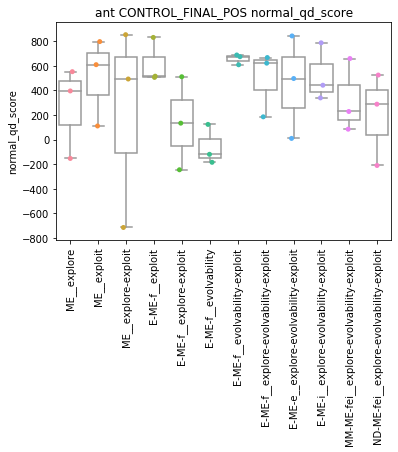

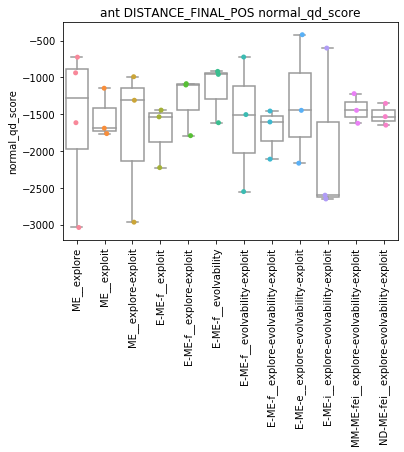

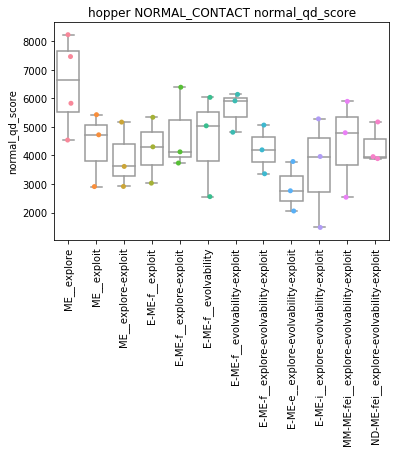

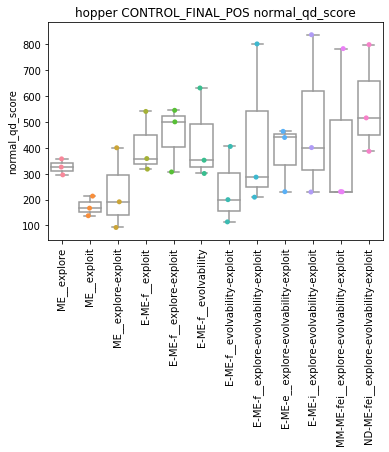

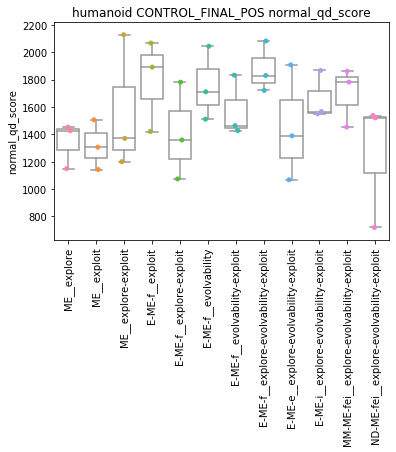

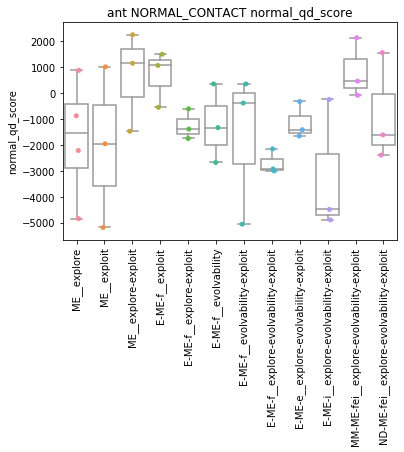

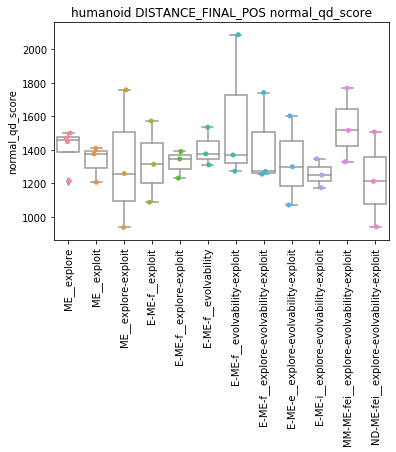

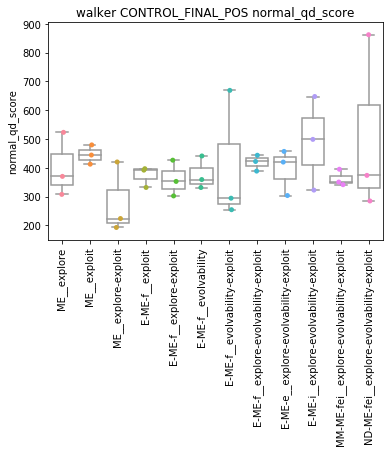

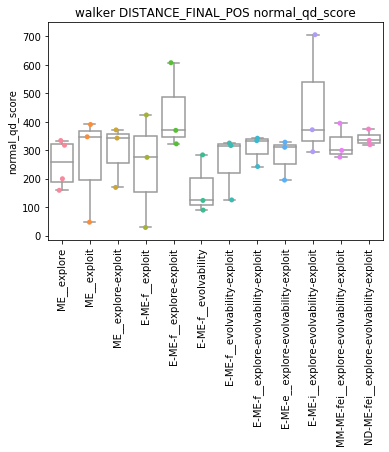

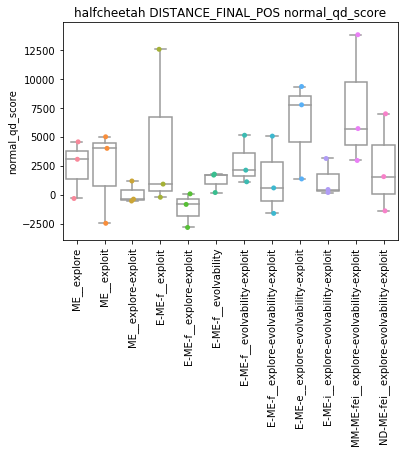

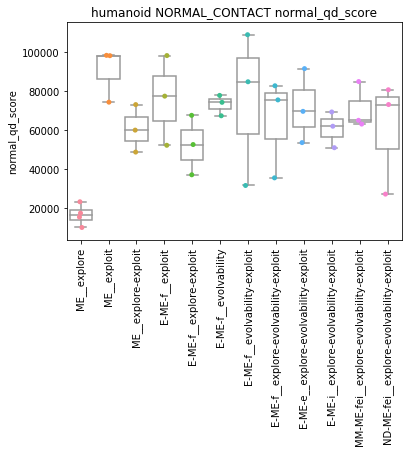

In [21]:
# seaborn plots
import seaborn as sns

metrics = [
    "best_normal_fitness",
    "best_distance_fitness",
    "non_empty_ratio",
    "normal_qd_score"
]

for metric in metrics:
    for env_combo in combinations:
        mask = (df["env_name"] == env_combo[0]) & (df["env_mode"] == env_combo[1])
        subset = df[mask]
        algo = custom_order[0]

        boxplot_data = [] 
        boxplot_labels = []

        for algo in custom_order:
            values = subset[subset["ALGO_NAME"]==algo][metric].astype(float)
            boxplot_data.append(values)
            boxplot_labels.append(algo)

        sns.boxplot(data=boxplot_data,color="white",saturation=0)#,whis=(0,100))
        sns.stripplot(data=boxplot_data)#,color="black")
        plt.xticks(list(range(len(boxplot_labels))),boxplot_labels,rotation = 90)
        plt.ylabel(metric)
        plt.title(env_combo[0]+" "+env_combo[1]+" "+metric)
        #plt.ylim(bottom=0)
        plt.show()

('ant', 'NORMAL_CONTACT') 36


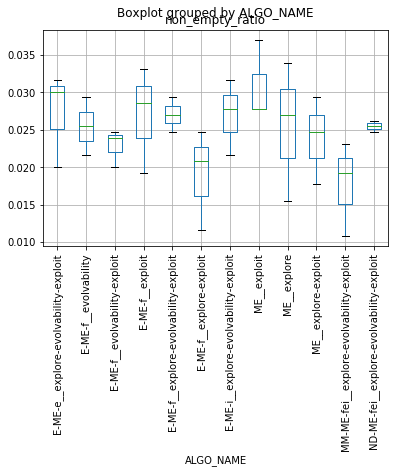

('humanoid', 'NORMAL_CONTACT') 37


/scratch/ak1774/vargpu_env/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


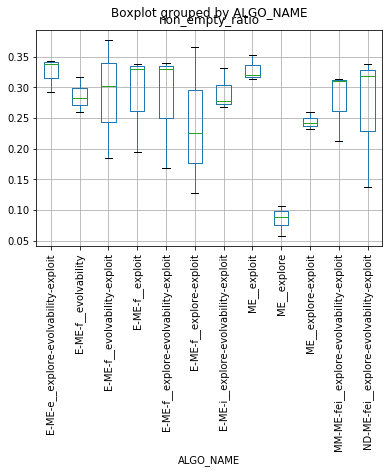

('ant', 'CONTROL_FINAL_POS') 36


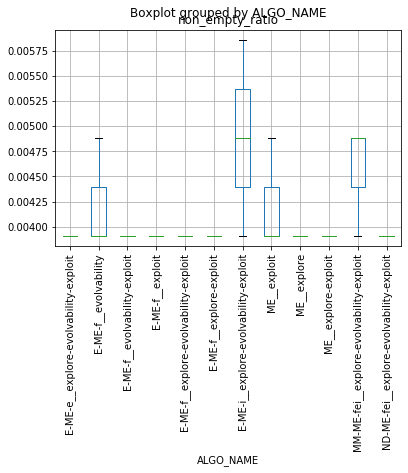

('hopper', 'DISTANCE_FINAL_POS') 36


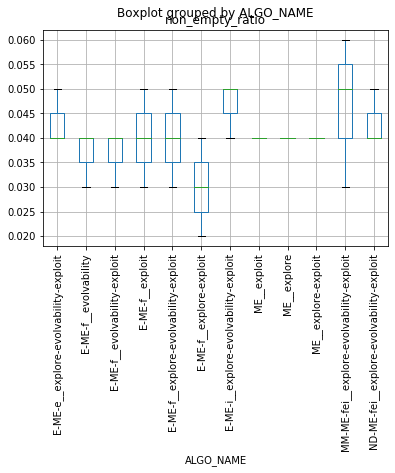

('walker', 'NORMAL_CONTACT') 37


/scratch/ak1774/vargpu_env/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


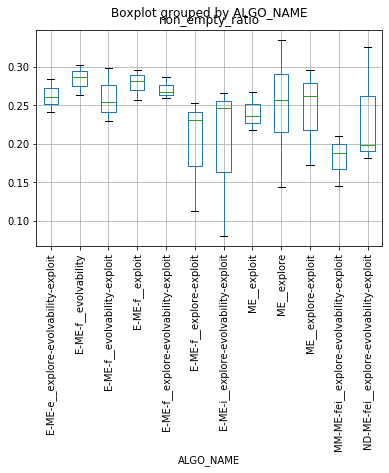

('humanoid', 'CONTROL_FINAL_POS') 36


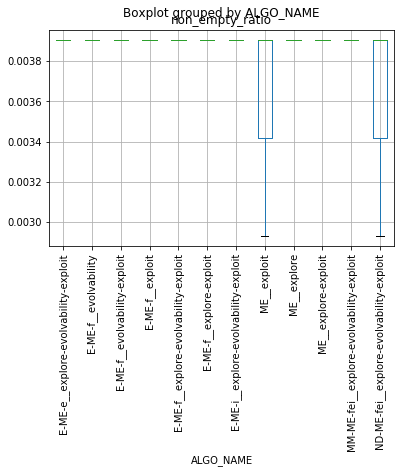

('humanoid', 'DISTANCE_FINAL_POS') 36


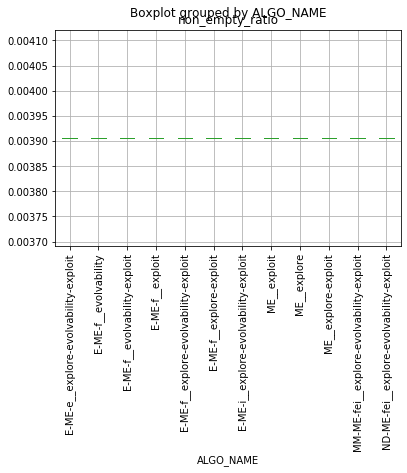

('ant', 'DISTANCE_FINAL_POS') 36


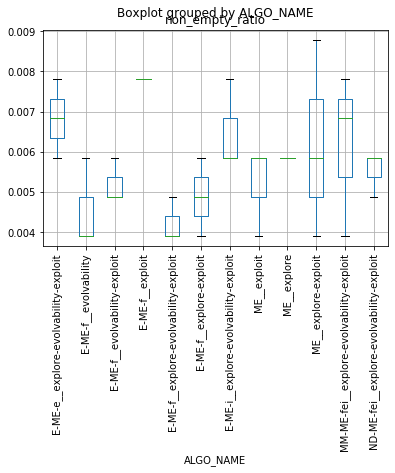

('walker', 'CONTROL_FINAL_POS') 36


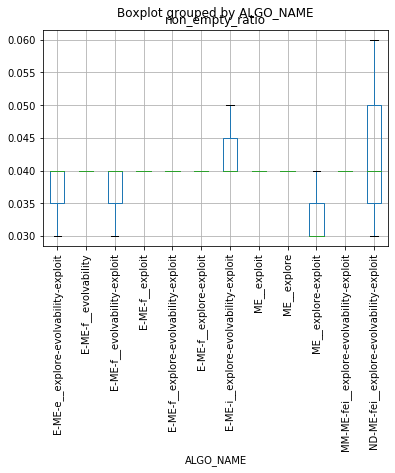

('walker', 'DISTANCE_FINAL_POS') 36


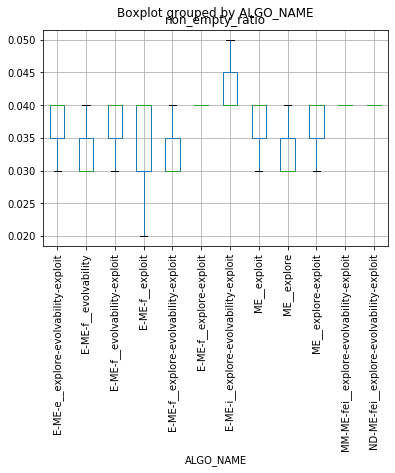

('halfcheetah', 'NORMAL_CONTACT') 36


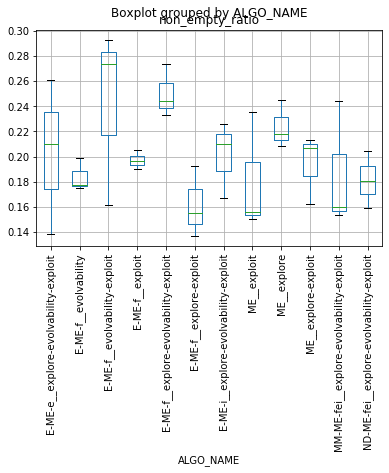

('halfcheetah', 'CONTROL_FINAL_POS') 35


/scratch/ak1774/vargpu_env/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


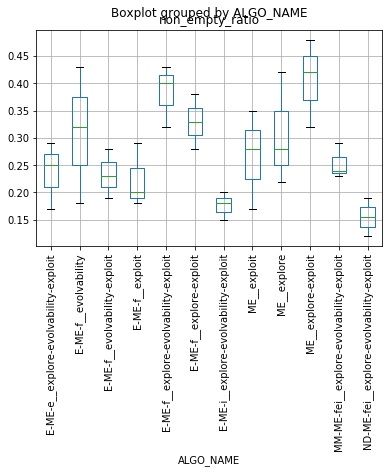

('halfcheetah', 'DISTANCE_FINAL_POS') 35


/scratch/ak1774/vargpu_env/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


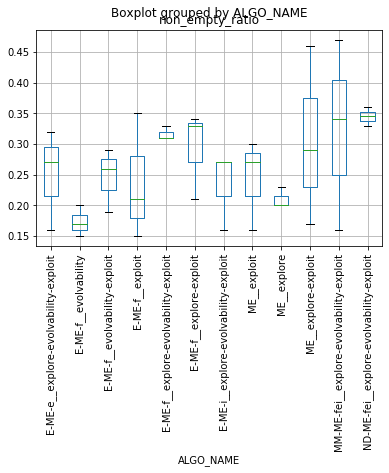

('hopper', 'NORMAL_CONTACT') 36


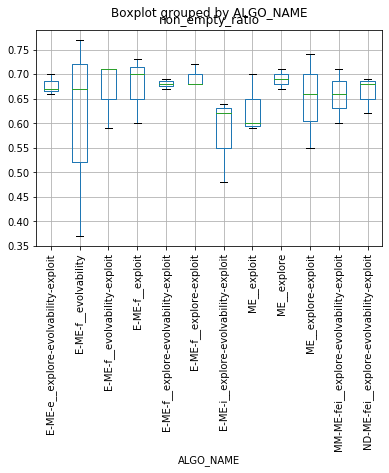

('hopper', 'CONTROL_FINAL_POS') 36


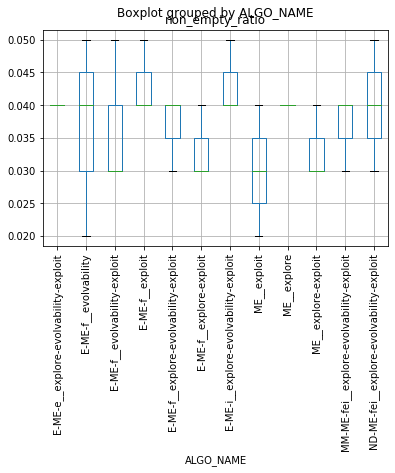

('ant', 'NORMAL_CONTACT') 36


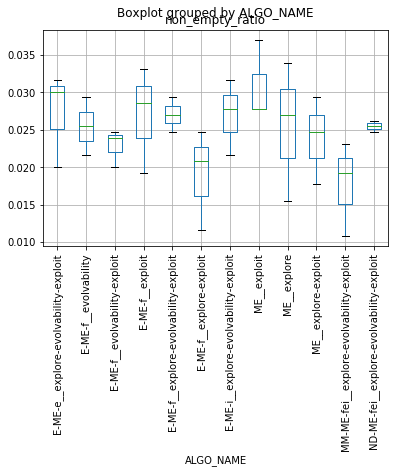

('humanoid', 'NORMAL_CONTACT') 37


/scratch/ak1774/vargpu_env/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


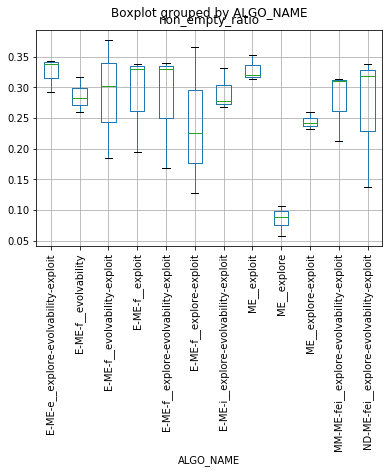

('ant', 'CONTROL_FINAL_POS') 36


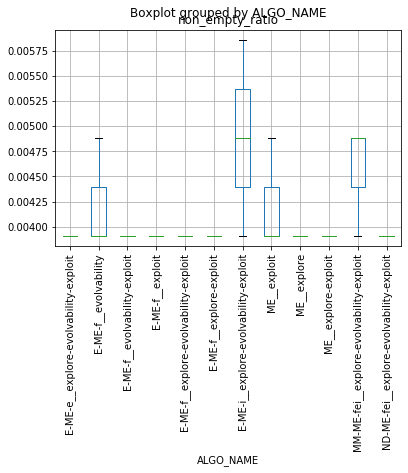

('hopper', 'DISTANCE_FINAL_POS') 36


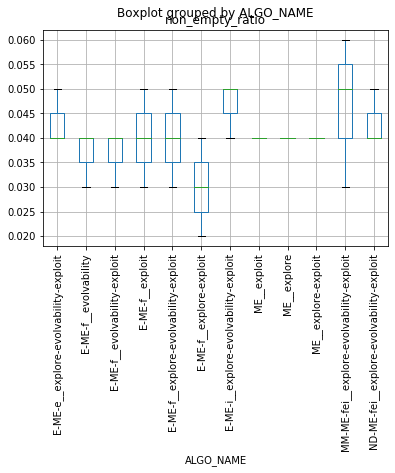

('walker', 'NORMAL_CONTACT') 37


/scratch/ak1774/vargpu_env/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


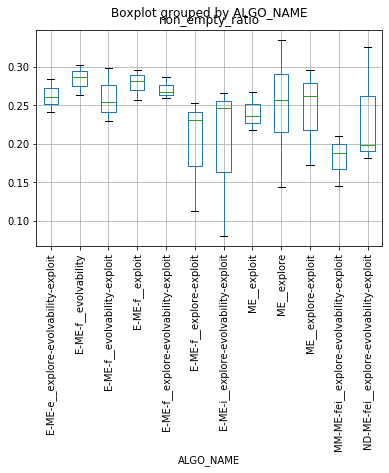

('humanoid', 'CONTROL_FINAL_POS') 36


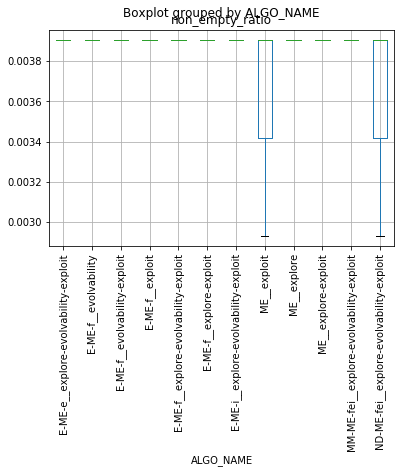

('humanoid', 'DISTANCE_FINAL_POS') 36


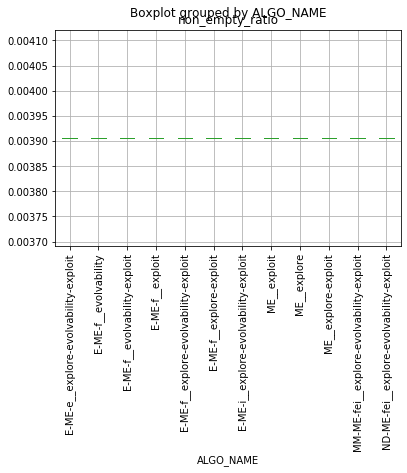

('ant', 'DISTANCE_FINAL_POS') 36


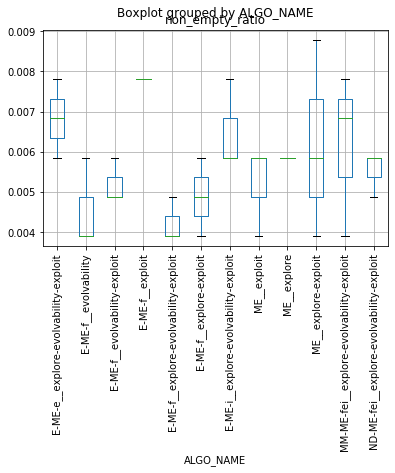

('walker', 'CONTROL_FINAL_POS') 36


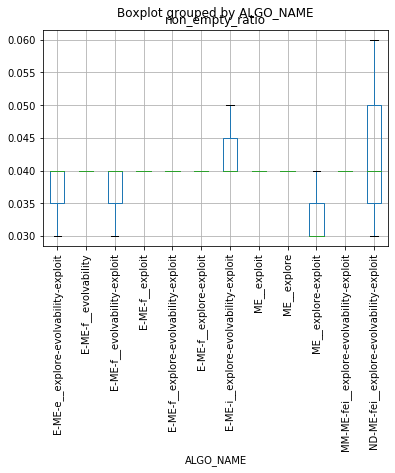

('walker', 'DISTANCE_FINAL_POS') 36


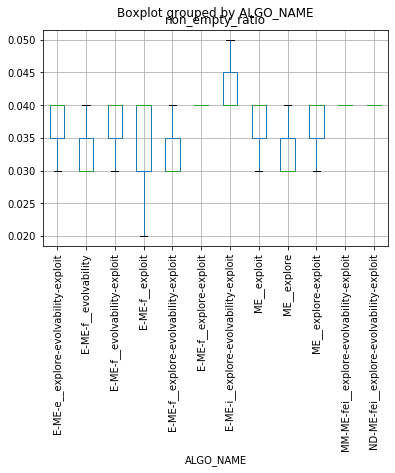

('halfcheetah', 'NORMAL_CONTACT') 36


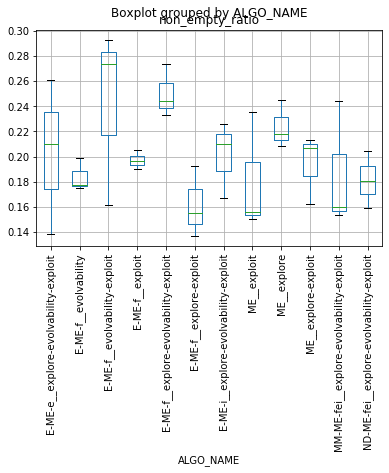

('halfcheetah', 'CONTROL_FINAL_POS') 35


/scratch/ak1774/vargpu_env/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


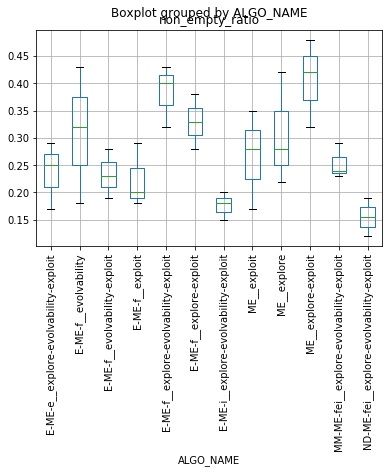

('halfcheetah', 'DISTANCE_FINAL_POS') 35


/scratch/ak1774/vargpu_env/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


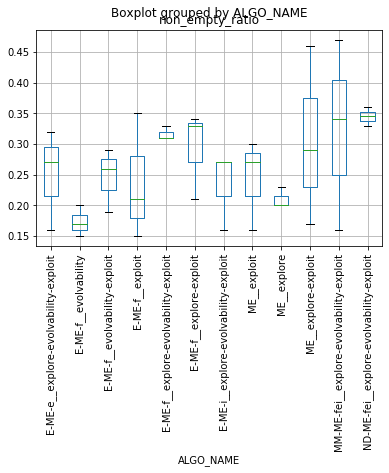

('hopper', 'NORMAL_CONTACT') 36


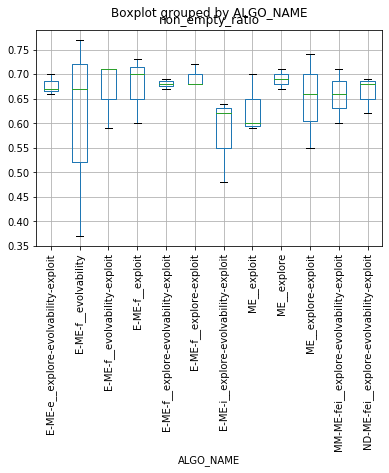

('hopper', 'CONTROL_FINAL_POS') 36


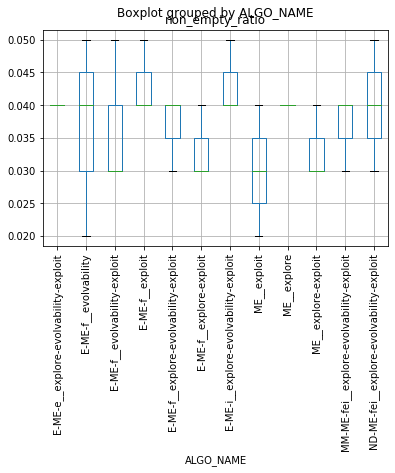

('ant', 'NORMAL_CONTACT') 36


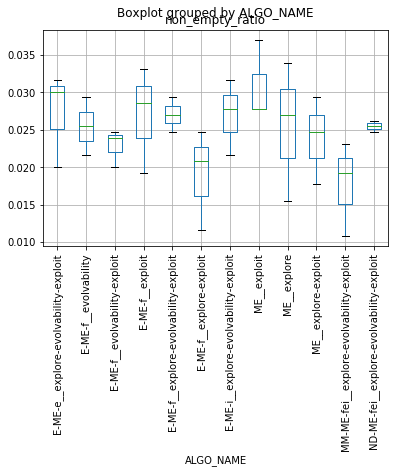

('humanoid', 'NORMAL_CONTACT') 37


/scratch/ak1774/vargpu_env/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


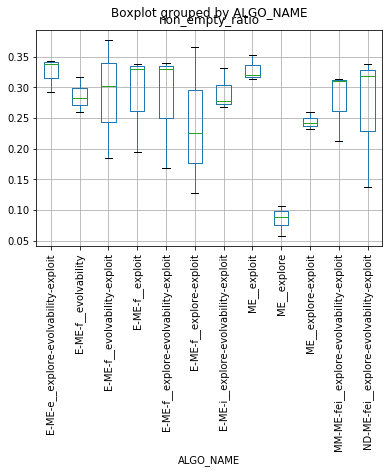

('ant', 'CONTROL_FINAL_POS') 36


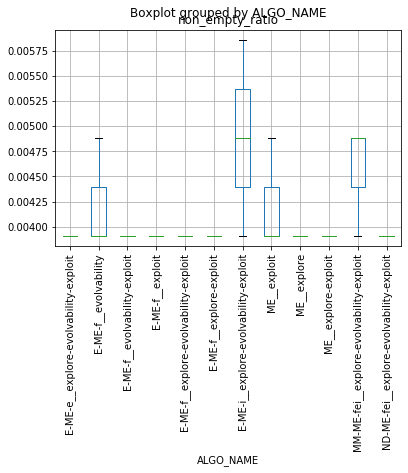

('hopper', 'DISTANCE_FINAL_POS') 36


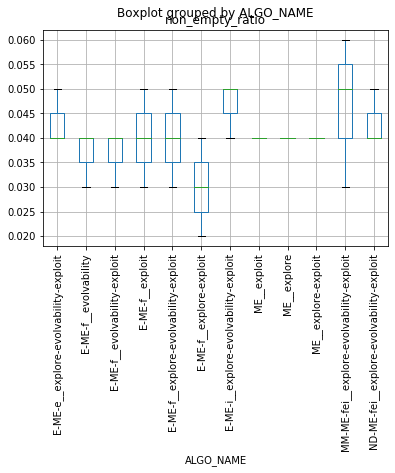

('walker', 'NORMAL_CONTACT') 37


/scratch/ak1774/vargpu_env/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


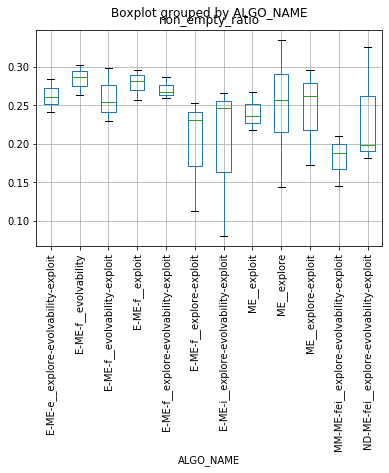

('humanoid', 'CONTROL_FINAL_POS') 36


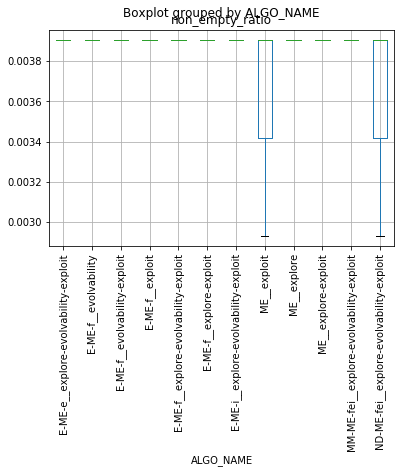

('humanoid', 'DISTANCE_FINAL_POS') 36


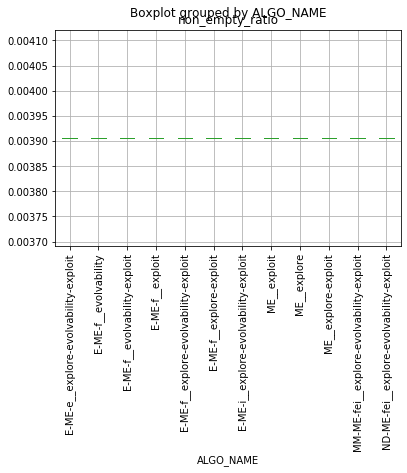

('ant', 'DISTANCE_FINAL_POS') 36


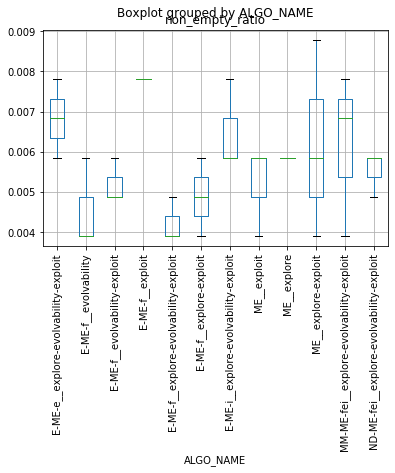

('walker', 'CONTROL_FINAL_POS') 36


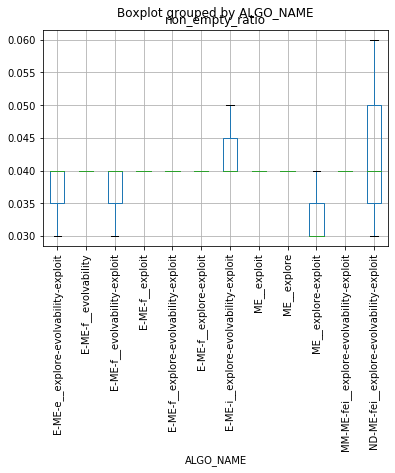

('walker', 'DISTANCE_FINAL_POS') 36


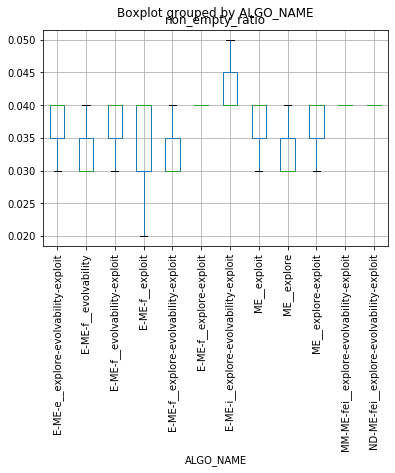

('halfcheetah', 'NORMAL_CONTACT') 36


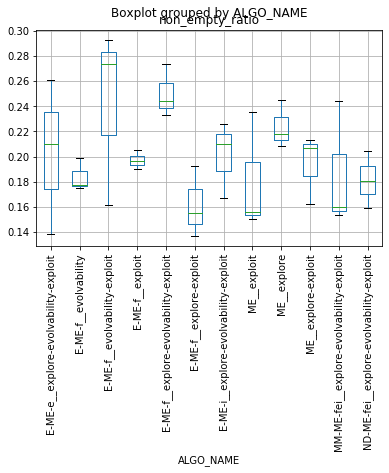

('halfcheetah', 'CONTROL_FINAL_POS') 35


/scratch/ak1774/vargpu_env/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


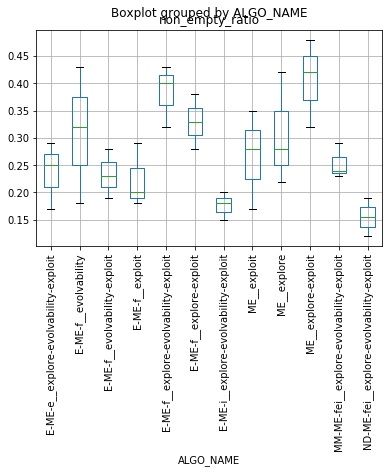

('halfcheetah', 'DISTANCE_FINAL_POS') 35


/scratch/ak1774/vargpu_env/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


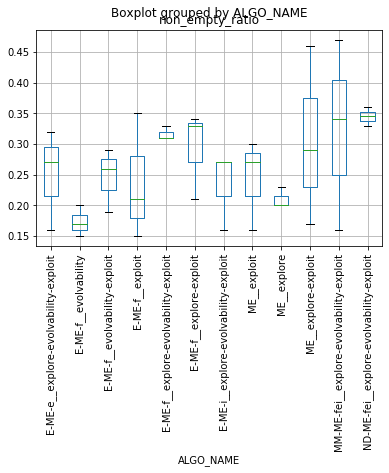

('hopper', 'NORMAL_CONTACT') 36


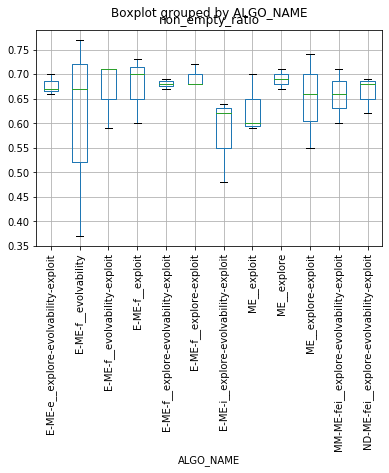

('hopper', 'CONTROL_FINAL_POS') 36


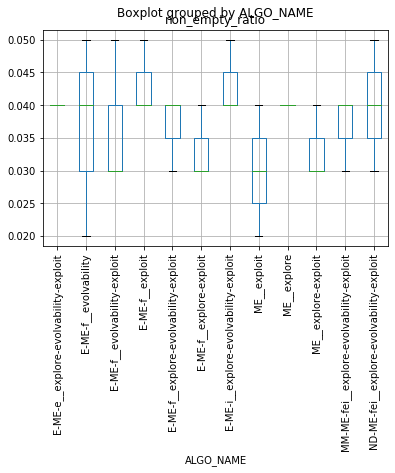

('ant', 'NORMAL_CONTACT') 36


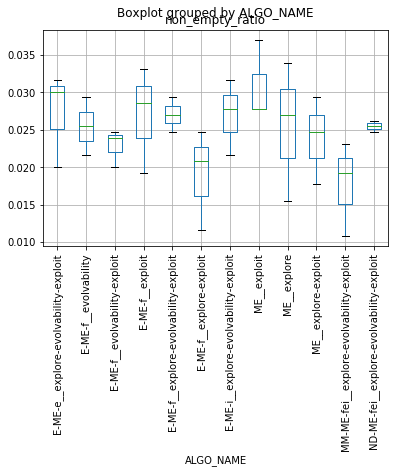

('humanoid', 'NORMAL_CONTACT') 37


/scratch/ak1774/vargpu_env/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


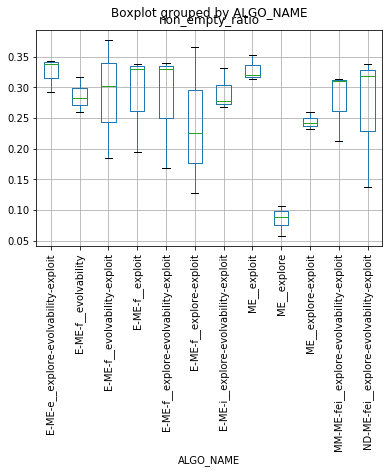

('ant', 'CONTROL_FINAL_POS') 36


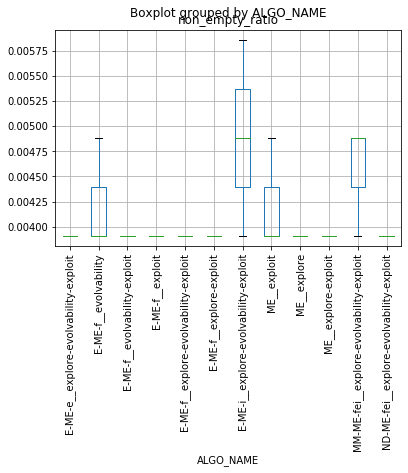

('hopper', 'DISTANCE_FINAL_POS') 36


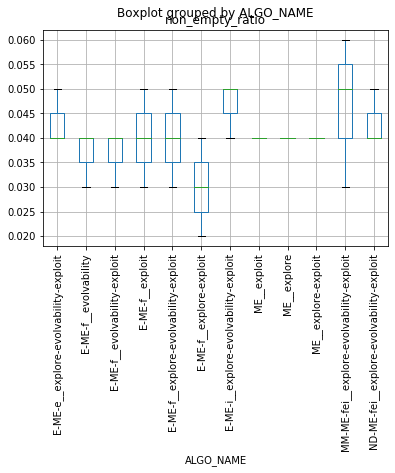

('walker', 'NORMAL_CONTACT') 37


/scratch/ak1774/vargpu_env/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


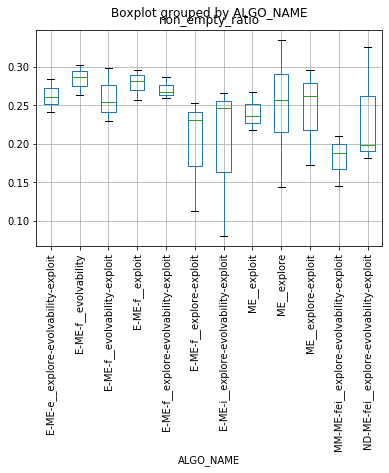

('humanoid', 'CONTROL_FINAL_POS') 36


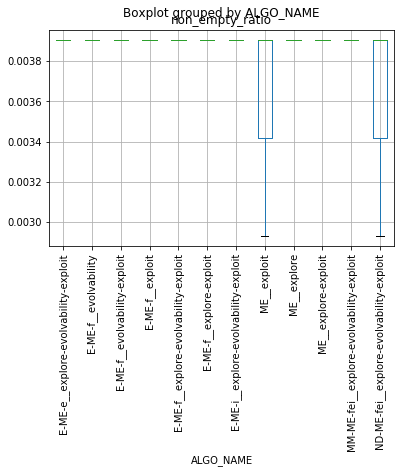

('humanoid', 'DISTANCE_FINAL_POS') 36


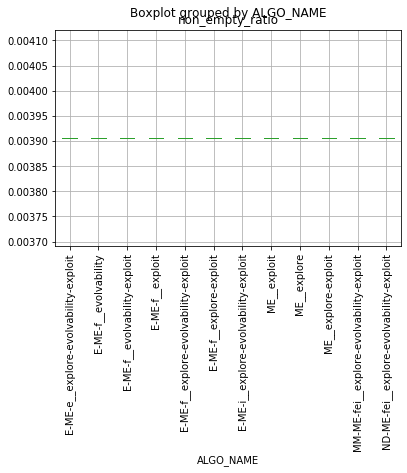

('ant', 'DISTANCE_FINAL_POS') 36


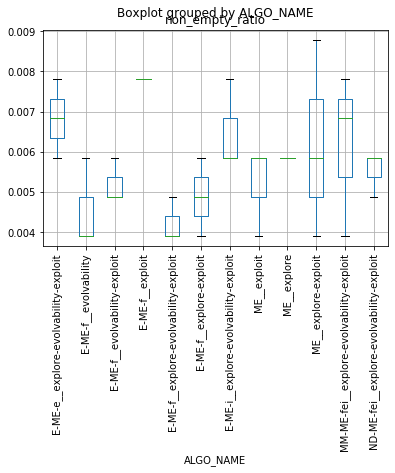

('walker', 'CONTROL_FINAL_POS') 36


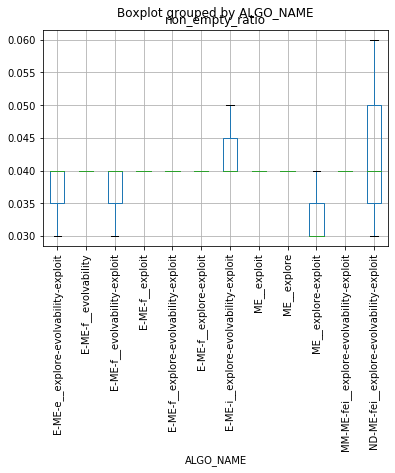

('walker', 'DISTANCE_FINAL_POS') 36


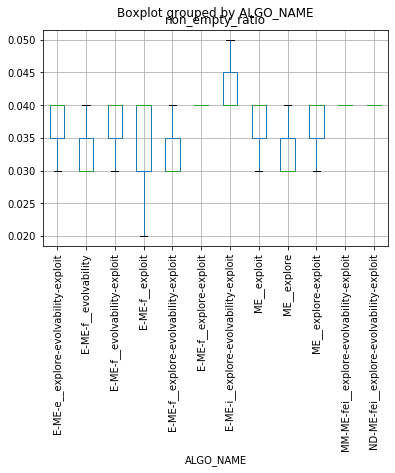

('halfcheetah', 'NORMAL_CONTACT') 36


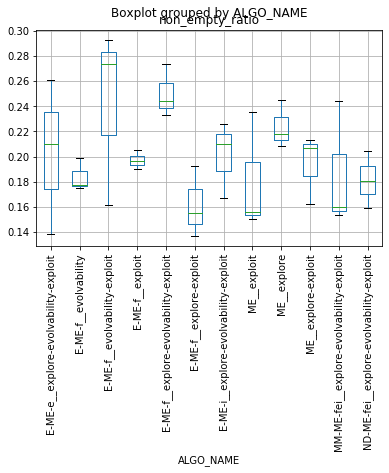

('halfcheetah', 'CONTROL_FINAL_POS') 35


/scratch/ak1774/vargpu_env/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


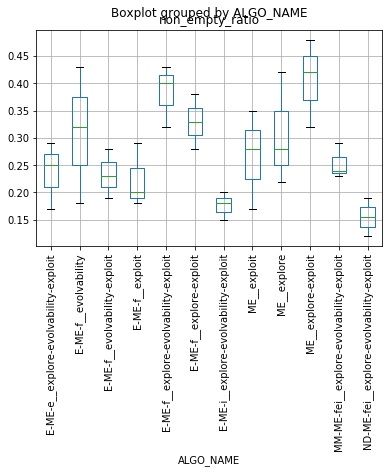

('halfcheetah', 'DISTANCE_FINAL_POS') 35


/scratch/ak1774/vargpu_env/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


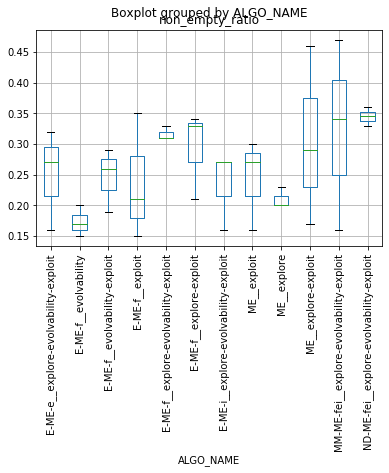

('hopper', 'NORMAL_CONTACT') 36


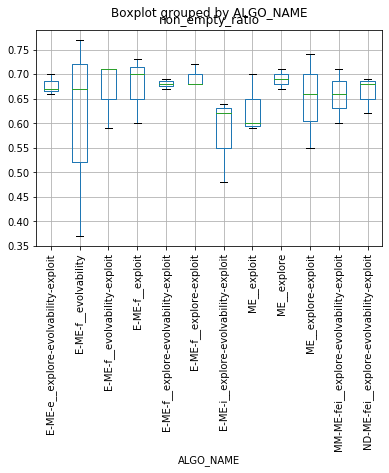

('hopper', 'CONTROL_FINAL_POS') 36


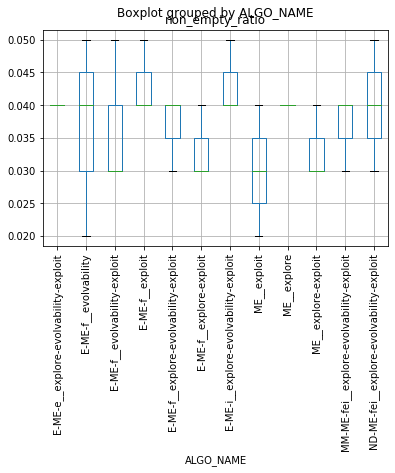

In [39]:
import seaborn as sns

#for env_combo in selected_combinations:
metrics = [
    "best_normal_fitness",
    "best_distance_fitness",
    "non_empty_ratio",
    "normal_qd_score"
]

for metric in metrics:
    for env_combo in combinations:   
        mask = (df["env_name"] == env_combo[0]) & (df["env_mode"] == env_combo[1])
        print(env_combo,sum(mask))
        #display(df[mask])
        # normal_qd_score
        # best_distance_fitness
        # non_empty_ratio

        # now we want to group the runs with the same 
        #env_data = df[mask].groupby(by='ALGO_NAME')
        #env_data.boxplot(column='non_empty_ratio',rot=45) # by='ALGO_NAME'
        df[mask].boxplot(column='non_empty_ratio', by='ALGO_NAME',rot=90) 
        plt.show()

In [19]:
# Go over all the hypothesis one by one
# Hipothesis 1, selecting for excpected fitness instead of eval fitness will help
# Hypothesis 2, adding evolvability update to the mix helps with everything
# Hypothesis 3, doing map insertion based on evolvability hepls
#  - sub question, is it better to do multi map or nd sorted map




In [35]:
for algo in set(df["ALGO_NAME"]):
    print(algo, sum(df["ALGO_NAME"] == algo) )


E-ME-i__explore-evolvability-exploit 10
E-ME-fei__explore-evolvability-exploit 17
E-ME-f__exploit 10
E-ME-e__explore-evolvability-exploit 10
E-ME-f__explore-evolvability-exploit 10
ME__explore-exploit 10
E-ME-f__evolvability 10
E-ME-f__evolvability-exploit 10
E-ME-f__explore-exploit 10
ME__exploit 10
ME__explore 10
